In [55]:
push!(LOAD_PATH, "..")
using ASE
using MatSciPy
using PyPlot
using PyCall
using TightBinding

In [56]:
# some parameters

# displacement of one atom
δ = 0.1
# temperature
TEMPE = 300

300

## 1. Carbon

In [77]:
at = bulk("C"; cubic=true)
at = repeat(at, (4, 4, 4))
set_pbc!(at, [true, true, true])
X = positions(at)

#plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
#plot3D(X[1,1:1], X[2,1:1], X[3,1:1], "ro")
print(length(at))
print(cell(at))

512[14.28 0.0 0.0
 0.0 14.28 0.0
 0.0 0.0 14.28]

In [78]:
import NRLTB
reload("TightBinding")
reload("NRLTB")

set_pbc!(at, [true, true, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)
tbm.nkpoints = (2,2,2)

# take a very low temperature  T=300 to approximate the fermi level at 0 temperature
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc0 = TightBinding.forces(at, tbm)
print(norm(frc0[:],Inf))

1.7737129504717613e-15

In [82]:
# Plot band structure

#EF = tbm.eF
#n = size(K,2)
#kk = zeros(n)
#for k = 1:n
#    kk[k] = norm(K[:,k])
#end
#plot(kk, E[1,:][:], "g.")
#plot(kk, E[2,:][:], "b.")
#plot(kk, E[3,:][:], "r.")
#plot(kk, E[4,:][:], "y.")
#plot(kk, ones(n)*EF, "k-" )

In [81]:
# move one atom and test the force

X[1,1] += δ
set_positions!(at, X)

# one nees to compute Fermi-level again
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc1 = TightBinding.forces(at, tbm)

3x512 Array{Float64,2}:
 -0.313142     0.0675388   -0.0100432   …   0.000117314  -0.000115551
 -2.80033e-16  0.00943545  -0.00540565      0.000113481  -0.000593763
 -3.08212e-16  0.00943545  -0.00540565     -5.82507e-5   -0.000293395

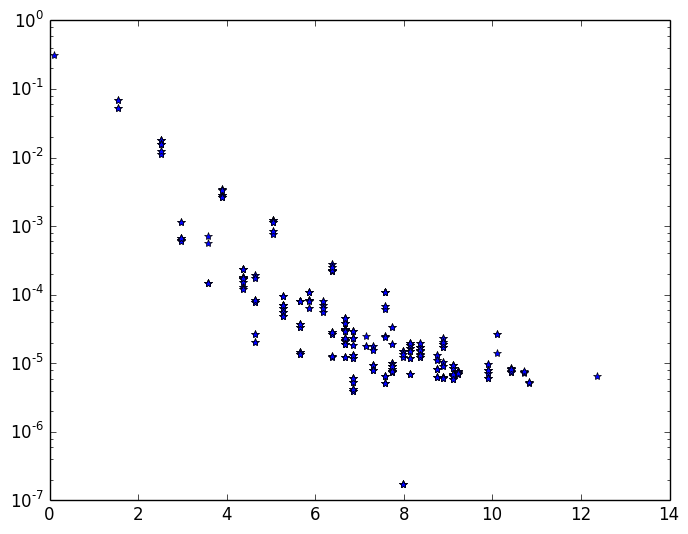

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x101bbdd0>

In [93]:
L = cell(at)[1,1]

F = zeros(length(at))
Z = zeros(length(at))  # periodic distance

for j = 1:length(at)
    F[j] = norm(frc1[:,j])
    Z[j] = min( norm(X[:,j]), norm(X[:,j]-[L, 0, 0]), 
                norm(X[:,j]-[0, L, 0]), norm(X[:,j]-[0, 0, L]), 
                norm(X[:,j]-[0, L, L]), norm(X[:,j]-[L, 0, L]), 
                norm(X[:,j]-[L, L, 0]), norm(X[:,j]-[L, L, L]) )
end
semilogy(Z, F, "*")

## 1^. Carbon with open boundary condition
### one can only test the force differences

In [123]:
at = bulk("C"; cubic=true)
at = repeat(at, (4, 4, 4))
set_pbc!(at, [false, false, false])
X = positions(at)

#plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
#plot3D(X[1,1:1], X[2,1:1], X[3,1:1], "ro")
print(length(at))
print(cell(at))

512[14.28 0.0 0.0
 0.0 14.28 0.0
 0.0 0.0 14.28]

In [124]:
import NRLTB
reload("TightBinding")
reload("NRLTB")

tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)
tbm.nkpoints = (0,0,0)

# take a very low temperature  T=300 to approximate the fermi level at 0 temperature
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc0 = TightBinding.forces(at, tbm)
print(norm(frc0[:],Inf))

2.1441014889845804

In [125]:
# move one atom and test the force

X[1,1] += δ
set_positions!(at, X)

# one nees to compute Fermi-level again
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc1 = TightBinding.forces(at, tbm)

3x512 Array{Float64,2}:
 0.428323  -0.13861     2.09232   …  -0.938173   0.799562  -0.938173
 0.444213  -0.0900892  -0.236377     -1.5025     0.800273  -0.939096
 0.444213  -0.0900892  -0.236377     -0.939096  -1.35296   -1.5025  

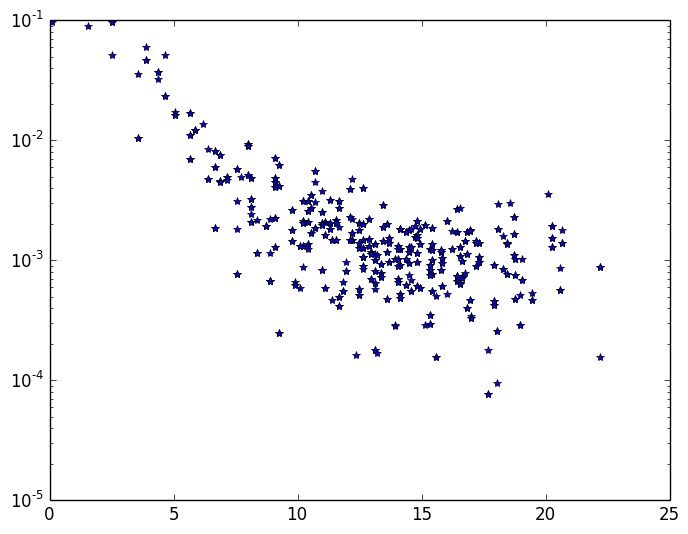

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x132da050>

In [126]:
L = cell(at)[1,1]

F = zeros(length(at))
Z = zeros(length(at))  # distance

for j = 1:length(at)
    F[j] = norm(frc1[:,j] - frc0[:,j])
    Z[j] = norm(X[:,j])
end
semilogy(Z, F, "*")

## 2. Carbon with a vacancy

In [97]:
using PyCall
@pyimport ase

X = positions(at)
na = length(at)
Y = zeros(3,na-1)
Y = X[:,1:na-1]

at_vac = ASEAtoms( ase.Atoms("C511") )
set_cell!(at_vac, cell(at))
set_positions!(at_vac, Y)
set_pbc!(at_vac, [true, true, true])
tbm.nkpoints = (2,2,2)

X_vac = positions(at_vac)
# plot3D(X_vac[1,:][:], X_vac[2,:][:], X_vac[3,:][:], "b.")
print(length(at_vac))

511

In [98]:
# fermi level
K, E = TightBinding.band_structure(at_vac, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at_vac, tbm)

# force
frc2 = TightBinding.forces(at_vac, tbm)

3x511 Array{Float64,2}:
 -0.178111   -0.0162433  0.0822377  …  -0.065312   -0.546492  -0.564789
  0.0392125  -0.0487731  0.0399516     -0.184517    0.703411  -0.615989
  0.187837   -0.0180373  0.0454351      0.0638688  -0.705785  -0.579065

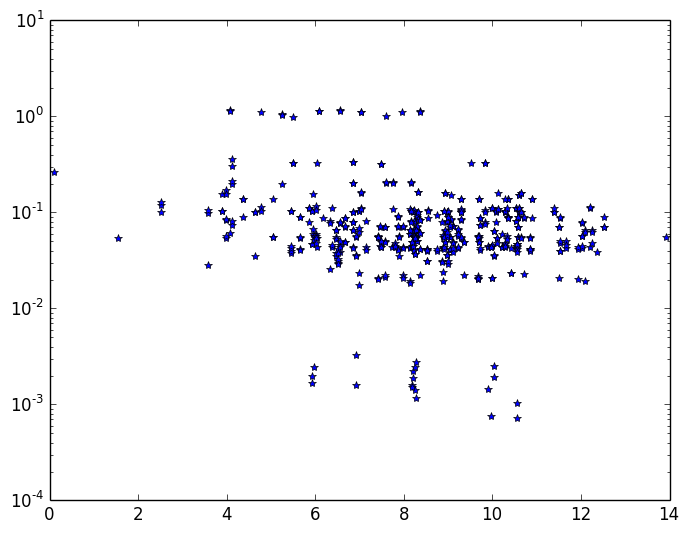

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12708890>

In [112]:
L = cell(at)[1,1]

F = zeros(length(at_vac))
Z = zeros(length(at_vac))  # periodic distance

for j = 1:length(at_vac)
    F[j] = norm(frc2[:,j])
    Z[j] = min( norm(Y[:,j]), norm(Y[:,j]-[L, 0, 0]), 
                norm(Y[:,j]-[0, L, 0]), norm(Y[:,j]-[0, 0, L]), 
                norm(Y[:,j]-[0, L, L]), norm(Y[:,j]-[L, 0, L]), 
                norm(Y[:,j]-[L, L, 0]), norm(Y[:,j]-[L, L, L]) )
end
semilogy(Z, F, "*")

## 3. Aluminimu

In [118]:
at = bulk("Al"; cubic=true)
at = repeat(at, (4, 4, 4))
set_pbc!(at, [true, true, true])
X = positions(at)

#plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
#plot3D(X[1,1:1], X[2,1:1], X[3,1:1], "ro")
print(length(at))
print(cell(at))

256[16.2 0.0 0.0
 0.0 16.2 0.0
 0.0 0.0 16.2]

In [119]:
import NRLTB
reload("TightBinding")
reload("NRLTB")

set_pbc!(at, [true, true, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)
tbm.nkpoints = (2,2,2)

# take a very low temperature  T=300 to approximate the fermi level at 0 temperature
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc0 = TightBinding.forces(at, tbm)
print(norm(frc0[:],Inf))

1.9335231536307556e-14

In [120]:
# move one atom and test the force

X[1,1] += δ
set_positions!(at, X)

# one nees to compute Fermi-level again
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc1 = TightBinding.forces(at, tbm)

3x256 Array{Float64,2}:
 -0.458136      0.137054    0.0420122    …  -0.0400408   -0.0400408 
 -1.95517e-15  -0.0313596  -3.17257e-15     -0.0093768    0.00881678
 -1.39224e-16  -0.0313596   0.0285193        0.00881678  -0.0093768 

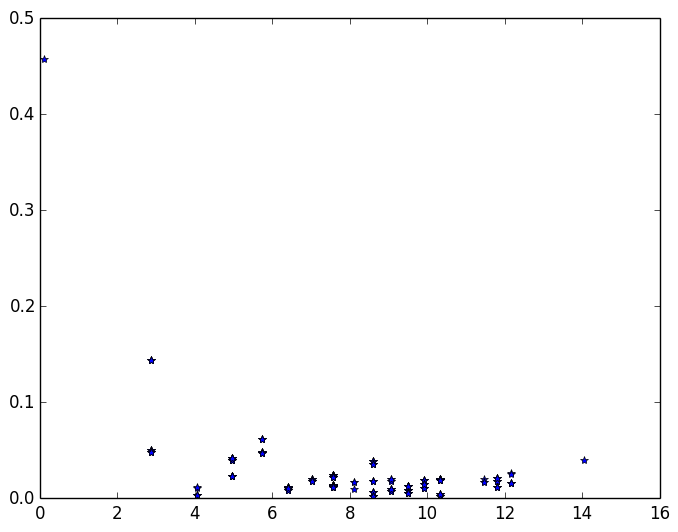

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x27c0c7d0>

In [121]:
L = cell(at)[1,1]

F = zeros(length(at))
Z = zeros(length(at))  # periodic distance

for j = 1:length(at)
    F[j] = norm(frc1[:,j])
    Z[j] = min( norm(X[:,j]), norm(X[:,j]-[L, 0, 0]), 
                norm(X[:,j]-[0, L, 0]), norm(X[:,j]-[0, 0, L]), 
                norm(X[:,j]-[0, L, L]), norm(X[:,j]-[L, 0, L]), 
                norm(X[:,j]-[L, L, 0]), norm(X[:,j]-[L, L, L]) )
end
plot(Z, F, "*")

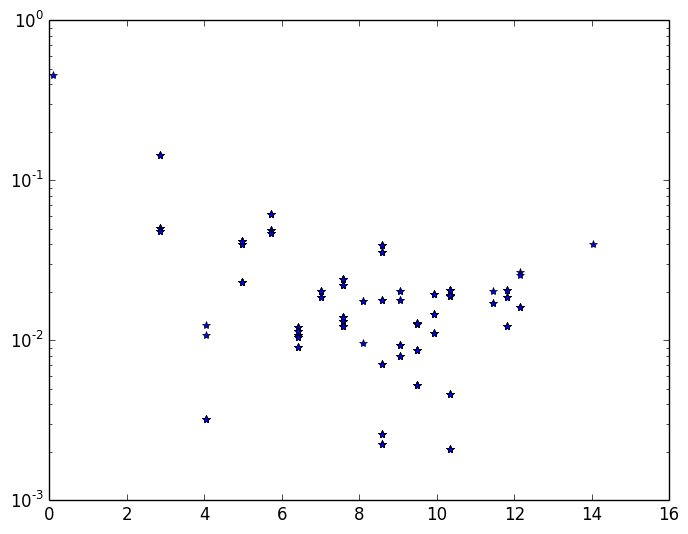

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x27c26d10>

In [122]:
semilogy(Z, F, "*")